In [ ]:
!pip install tensorflowjs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"risnadwiindriani","key":"3e70e6c9730fa87aabfca6efa992dcb8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ekojsalim/indonesia-college-entrance-examination-utbk-2019
!unzip indonesia-college-entrance-examination-utbk-2019.zip

Dataset URL: https://www.kaggle.com/datasets/ekojsalim/indonesia-college-entrance-examination-utbk-2019
License(s): unknown
  0% 0.00/3.75M [00:00<?, ?B/s]
100% 3.75M/3.75M [00:00<00:00, 809MB/s]
Archive:  indonesia-college-entrance-examination-utbk-2019.zip
  inflating: majors.csv              
  inflating: score_humanities.csv    
  inflating: score_science.csv       
  inflating: universities.csv        


In [ ]:
# read dataset major & univ
major = pd.read_csv('majors.csv', index_col=0)
univ = pd.read_csv('universities.csv', index_col=0)

# Menambahkan dua kolom baru di DataFrame major
major['utbk_capacity'], major['passed_count']= (0.4 * major['capacity']).apply(int), 0

# merge major & univ
major_univ = pd.merge(major, univ, on = 'id_university', how = 'left')
major_univ.set_index('id_major', inplace = True)
major_univ.head()

,id_university,type,major_name,capacity,utbk_capacity,passed_count,university_name
id_major,,,,,,,
1111014,111,science,PENDIDIKAN DOKTER HEWAN,88,35,0,UNIVERSITAS SYIAH KUALA
1111022,111,science,TEKNIK SIPIL,64,25,0,UNIVERSITAS SYIAH KUALA
1111037,111,science,TEKNIK MESIN,48,19,0,UNIVERSITAS SYIAH KUALA
1111045,111,science,TEKNIK KIMIA,48,19,0,UNIVERSITAS SYIAH KUALA
1111053,111,science,ARSITEKTUR,48,19,0,UNIVERSITAS SYIAH KUALA


In [ ]:
# read dataset science
sci_score = pd.read_csv('score_science.csv', index_col=0)

# hitung rata-rata nilai
sci_score['general_score'] = sci_score[['score_kpu', 'score_kua', 'score_ppu', 'score_kmb']].apply(np.mean, axis = 1)
sci_score['specialize_score'] = sci_score[['score_mat', 'score_fis', 'score_kim', 'score_bio']].apply(np.mean, axis = 1)
sci_score['score_mean'] = sci_score[['score_mat', 'score_fis', 'score_kim', 'score_bio', 'score_kpu', 'score_kua', 'score_ppu','score_kmb']].apply(np.mean, axis = 1)

# drop kolom
sci_score.drop(['score_mat', 'score_fis', 'score_kim', 'score_bio', 'score_kpu', 'score_kua', 'score_ppu', 'score_kmb'], axis = 1,inplace = True)
sci_score.head()

,id_first_major,id_first_university,id_second_major,id_second_university,id_user,general_score,specialize_score,score_mean
0,3321065,332,3331187,333,4,400.00,400.00,400.000
1,3211015,321,3611066,361,14,657.75,707.00,682.375
2,3721093,372,3551302,355,19,653.25,644.00,648.625
3,3321096,332,3551194,355,23,689.25,642.00,665.625
4,5211104,521,5211085,521,28,506.50,546.75,526.625


In [ ]:
# read dataset humanities
hum_score = pd.read_csv('score_humanities.csv', index_col=0)

# hitung nilai rata-rata
hum_score['general_score'] = hum_score[['score_kpu', 'score_kua', 'score_ppu', 'score_kmb']].apply(np.mean, axis = 1)
hum_score['specialize_score'] = hum_score[['score_mat', 'score_geo', 'score_sej', 'score_sos', 'score_eko']].apply(np.mean, axis = 1)
hum_score['score_mean'] = hum_score[['score_mat', 'score_geo', 'score_sej', 'score_sos', 'score_eko', 'score_kpu', 'score_kua', 'score_ppu','score_kmb']].apply(np.mean, axis = 1)

# drop kolom
hum_score.drop(['score_mat', 'score_geo', 'score_sej', 'score_sos', 'score_eko', 'score_kpu', 'score_kua', 'score_ppu', 'score_kmb'], axis = 1, inplace = True)
hum_score.head()

,id_first_major,id_first_university,id_second_major,id_second_university,id_user,general_score,specialize_score,score_mean
0,3322014,332,3532154,353,26,618.75,603.6,610.333333
1,3212057,321,3322022,332,35,714.50,617.4,660.555556
2,3722057,372,1912042,191,44,432.25,523.2,482.777778
3,3212081,321,3212301,321,55,615.00,579.2,595.111111
4,3812106,381,3852034,385,171,646.25,644.2,645.111111


In [ ]:
# periksa kesesuaian antara major & univ
def major_univ_check (cols):
    major_id = str(cols[0])
    univ_id = str(cols[1])
    major_type = cols[2]
    test_type = cols[3]

    if (major_type == test_type) & (major_id[:len(univ_id)] == univ_id):return True
    else:return False

def pass_indicator(note, major = '-', univ = '-'):
    return note, major, univ

In [ ]:
# Menetapkan Tipe Tes
sci_score['test_type'] = 'science'
hum_score['test_type'] = 'humanities'

# merge data
test_score = pd.merge(sci_score, hum_score, how = 'outer')
test_score = pd.merge(test_score, major_univ[['major_name', 'university_name', 'type']], left_on = 'id_first_major',
                      right_on = major_univ.index, how = 'left')
test_score = pd.merge(test_score, major_univ[['major_name', 'university_name', 'type']], left_on = 'id_second_major',
                      right_on = major_univ.index, how = 'left', suffixes = ('_1', '_2'))

# Menambahkan Kolom Baru
test_score.set_index('id_user', inplace = True)
test_score['pass_id_major'] = np.nan
test_score['pass_major'], test_score['pass_universities'], test_score['note'] = '', '', ''

# drop data yang tidak falid
drop_index = list(test_score[(~test_score['id_first_major'].isin(major_univ.index)) &
                        (~test_score['id_second_major'].isin(major_univ.index))].index)

# Memeriksa Kesesuaian Jenis Tes
test_score['major_1_check'] = test_score[['id_first_major', 'id_first_university', 'type_1', 'test_type']].apply(major_univ_check, axis = 1)
test_score['major_2_check'] = test_score[['id_second_major', 'id_second_university', 'type_2', 'test_type']].apply(major_univ_check, axis = 1)

# identifikasi index yang tidak valid
false_major_index = list(test_score[(test_score['major_1_check'] == False) & (test_score['major_2_check'] == False)].index)

# error handling
try:test_score.loc[drop_index + false_major_index, ['note', 'pass_major', 'pass_universities']] = pass_indicator('Error: invalid major/university')
except:pass

# drop kolom yang tidak diperlukan lagi
test_score.drop(['type_1', 'type_2'], axis = 1, inplace = True)
test_score.sort_values('score_mean', ascending = False, inplace = True)
test_score.head()

,id_first_major,id_first_university,id_second_major,id_second_university,general_score,specialize_score,score_mean,test_type,major_name_1,university_name_1,major_name_2,university_name_2,pass_id_major,pass_major,pass_universities,note,major_1_check,major_2_check
id_user,,,,,,,,,,,,,,,,,,
315473,7111196,711,3331156,333,845.75,925.25,885.500,science,PENDIDIKAN DOKTER GIGI,UNIVERSITAS HASANUDDIN,TEKNIK PERTANIAN,UNIVERSITAS PADJADJARAN,NaN,,,,True,True
186376,3211216,321,7121167,712,830.00,929.00,879.500,science,TEKNIK KOMPUTER,UNIVERSITAS INDONESIA,PENDIDIKAN TEKNIK INFORMATIKA & KOMPUTER,UNIVERSITAS NEGERI MAKASSAR,NaN,,,,True,True
155969,3211077,321,3331164,333,834.00,891.25,862.625,science,FARMASI,UNIVERSITAS INDONESIA,FARMASI,UNIVERSITAS PADJADJARAN,NaN,,,,True,True
172857,3321073,332,3211015,321,840.00,869.75,854.875,science,SEKOLAH TEK. ELEKTRO & INFORMATIKA (STEI),INSTITUT TEKNOLOGI BANDUNG,PENDIDIKAN DOKTER,UNIVERSITAS INDONESIA,NaN,,,,True,True
312199,3321096,332,3321107,332,849.25,854.25,851.750,science,FAKULTAS TEKNIK MESIN & DIRGANTARA (FTMD),INSTITUT TEKNOLOGI BANDUNG,"SEK. ARSITEKTUR, PERENC & PENGEMB KEBIJAKAN",INSTITUT TEKNOLOGI BANDUNG,NaN,,,,True,True


In [ ]:
# proses seleksi
for uid in tqdm(test_score[test_score['note'] == ''].index):
    row = test_score.loc[uid]
    major_1, major_2 = row['id_first_major'], row['id_second_major']

    if row['major_1_check'] and major_univ.loc[major_1, 'passed_count'] < major_univ.loc[major_1, 'utbk_capacity']:
        test_score.loc[uid, ['note', 'pass_major', 'pass_universities']] = pass_indicator(
            'Pass: First Choice', row['major_name_1'], row['university_name_1']
        )
        test_score.at[uid, 'pass_id_major'] = major_1
        major_univ.loc[major_1, 'passed_count'] += 1

    elif row['major_2_check'] and major_univ.loc[major_2, 'passed_count'] < major_univ.loc[major_2, 'utbk_capacity']:
        test_score.loc[uid, ['note', 'pass_major', 'pass_universities']] = pass_indicator(
            'Pass: Second Choice', row['major_name_2'], row['university_name_2']
        )
        test_score.at[uid, 'pass_id_major'] = major_2
        major_univ.loc[major_2, 'passed_count'] += 1

    else:
        test_score.loc[uid, ['note', 'pass_major', 'pass_universities']] = pass_indicator(
            'Failed: not passing any major choices'
        )
# drop kolom
test_score.drop(
    ['major_name_1', 'university_name_1', 'major_1_check','major_name_2', 'university_name_2', 'major_2_check'],
    axis=1,
    inplace=True
)

# normalisasi label note
test_score['note'].replace({
    'Failed: not passing any major choices':'0',
    'Pass: First Choice':'1',
    'Pass: Second Choice':'2'
}, inplace=True)

# filter index yang tidak falid
test_score = test_score[test_score['note'] != 'Error: invalid major/university']
test_score.head()

  0%|          | 0/147750 [00:00<?, ?it/s]

,id_first_major,id_first_university,id_second_major,id_second_university,general_score,specialize_score,score_mean,test_type,pass_id_major,pass_major,pass_universities,note
id_user,,,,,,,,,,,,
315473,7111196,711,3331156,333,845.75,925.25,885.500,science,7111196.0,PENDIDIKAN DOKTER GIGI,UNIVERSITAS HASANUDDIN,1
186376,3211216,321,7121167,712,830.00,929.00,879.500,science,3211216.0,TEKNIK KOMPUTER,UNIVERSITAS INDONESIA,1
155969,3211077,321,3331164,333,834.00,891.25,862.625,science,3211077.0,FARMASI,UNIVERSITAS INDONESIA,1
172857,3321073,332,3211015,321,840.00,869.75,854.875,science,3321073.0,SEKOLAH TEK. ELEKTRO & INFORMATIKA (STEI),INSTITUT TEKNOLOGI BANDUNG,1
312199,3321096,332,3321107,332,849.25,854.25,851.750,science,3321096.0,FAKULTAS TEKNIK MESIN & DIRGANTARA (FTMD),INSTITUT TEKNOLOGI BANDUNG,1


In [ ]:
# pilih kolom yang akan digunakan
dataset = test_score[['id_first_major','id_first_university','id_second_major','id_second_university',
                      'general_score', 'specialize_score', 'score_mean','test_type','note']]

# encode
dataset['test_type'] = dataset['test_type'].map({'science': 0, 'humanities': 1})
dataset['note'] = dataset['note'].map({'0':0,'1':1,'2':1})
dataset['note'] = dataset['note'].astype(int)
dataset.head()

,id_first_major,id_first_university,id_second_major,id_second_university,general_score,specialize_score,score_mean,test_type,note
id_user,,,,,,,,,
315473,7111196,711,3331156,333,845.75,925.25,885.500,0,1
186376,3211216,321,7121167,712,830.00,929.00,879.500,0,1
155969,3211077,321,3331164,333,834.00,891.25,862.625,0,1
172857,3321073,332,3211015,321,840.00,869.75,854.875,0,1
312199,3321096,332,3321107,332,849.25,854.25,851.750,0,1


In [ ]:
# save dataset final
dataset.to_excel('dataset.xlsx',index=False)

In [ ]:
# read dataset
dataset = pd.read_excel('dataset.xlsx')
dataset.head()

,id_first_major,id_first_university,id_second_major,id_second_university,general_score,specialize_score,score_mean,test_type,note
0,7111196,711,3331156,333,845.75,925.25,885.500,0,1
1,3211216,321,7121167,712,830.00,929.00,879.500,0,1
2,3211077,321,3331164,333,834.00,891.25,862.625,0,1
3,3321073,332,3211015,321,840.00,869.75,854.875,0,1
4,3321096,332,3321107,332,849.25,854.25,851.750,0,1


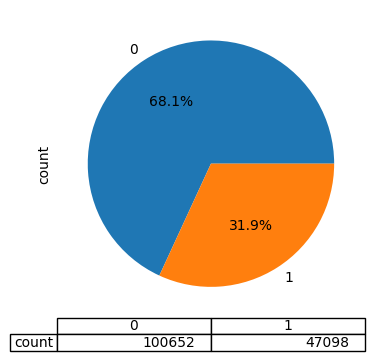

In [ ]:
# visualisasi
kelulusan = dataset['note'].value_counts()
kelulusan.plot.pie(
    figsize=(4,4),
    table=True,
    autopct='%1.1f%%'
)

plt.show()

In [ ]:
# train_test_split
X = dataset.drop('note', axis = 1)
y = dataset['note']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# normalisasi
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.1),

    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=25, validation_data=(X_test_scaled, y_test),
                    callbacks=callbacks, class_weight=class_weights)

Epoch 1/25
3233/3233 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.7025 - loss: 0.5561 - val_accuracy: 0.7360 - val_loss: 0.4822
Epoch 2/25
3233/3233 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7227 - loss: 0.5145 - val_accuracy: 0.7307 - val_loss: 0.4884
Epoch 3/25
3233/3233 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7232 - loss: 0.5107 - val_accuracy: 0.7391 - val_loss: 0.4990
Epoch 4/25
3233/3233 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7312 - loss: 0.5057 - val_accuracy: 0.7450 - val_loss: 0.4908
Epoch 5/25
3233/3233 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7324 - loss: 0.5052 - val_accuracy: 0.7322 - val_loss: 0.4997
Epoch 6/25
3233/3233 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7287 - loss: 0.5057 - val_accuracy: 0.7477 - val_loss: 0.4858


In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Test Loss: 0.4822
Test Accuracy: 0.7360


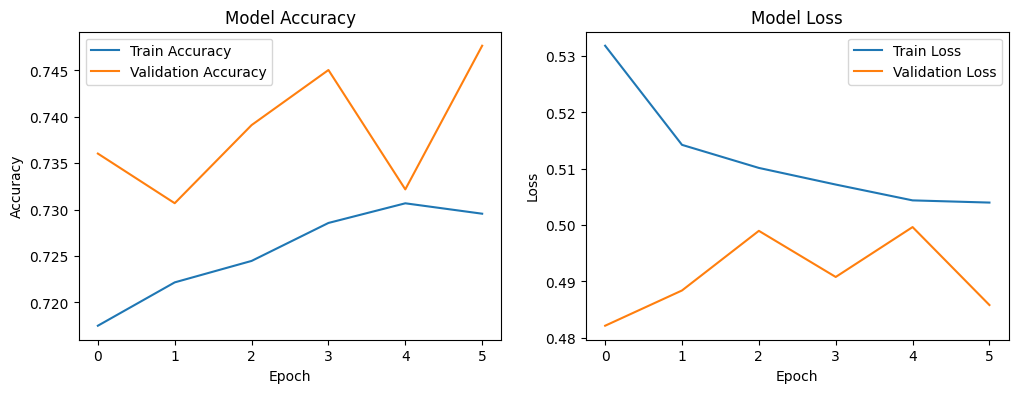

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,317 (552.02 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 93,700 (366.02 KB)

In [ ]:
keras.saving.save_model(model, "my_model.h5")

In [ ]:
!tensorflowjs_converter --input_format=keras my_model.h5 tfjs_model/

2025-06-04 12:33:52.638201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749040432.658021    4339 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749040432.663880    4339 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
from google.colab import files
import shutil
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>